# Notebook 1: MED-PC Extracting the Recording Data and Metadata

# Importing the Python Libraries

In [123]:
import sys
import glob
from collections import defaultdict
import os
from datetime import datetime

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from medpc2excel.medpc_read import medpc_read
from moviepy.editor import *
from IPython.display import Video

In [125]:
# setting path
sys.path.append('../../src')

In [126]:
# All the libraries that were created for this repository
import extract.dataframe
import processing.tone
import extract.metadata

In [127]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Getting the Metadata from all the MED-PC Recording Files

- Every MED-PC Recording file has Metadata about time, data, subject, group, experiment name, script used, and the MED-PC box number on the top of the recording file. We will first extract that information
    - Metadata can be background information or context about data(or files) that is often different from the actual data that is intended to be recorded.  
        For more information on Metadata: https://en.wikipedia.org/wiki/Metadata

In [128]:
all_med_pc_file = glob.glob("./data/**/*.txt", recursive=True)

- The path of the directory that this notebook is in. This will be where relative paths will be based off of

In [129]:
current_working_directory = os.getcwd()
current_working_directory

'/Users/kaavya/Documents/GitHub/behavioral_dataframe_processing/jupyter_notebooks/MED_PC'

- All the other files in this directory. If you want to use a folder in here such as the `data` folder, you'd type `./data/{name_of_folder}` where you replace `{name_of_folder}` with the name of the folder without the `{}`. You will do this in the cells following the one below
    - The `./` means the path will reference the current directory that the command is being used from

In [130]:
os.listdir(current_working_directory)

['proc',
 'med_pc_full.ipynb',
 '02_latencies.ipynb',
 '.DS_Store',
 'README.MD',
 '.03_port_entry_precision.ipynb.icloud',
 '01_extracting_recording_data.ipynb',
 '.ipynb_checkpoints',
 '04_syncing_with_video.ipynb',
 'data']

## NOTE: If you are using your own data, the following path must be changed to the directory where your MED-PC recording files are located(if they are not in the specied folder). It is recommended to create a sub folder in the `data` folder(that is in the same folder as this notebook) for each group of session you want to process and put the recording files in there

- Use the cell below instead if you're using your own data. You must change the cell below by clicking on the cell and then pressing the `esc` key. Then press the `Y` button on your keyboard. If you want to switch it back do the same but press the `R` button instead. This switches it from a cell that is run as if it's code, or back to a cell where it's just treated as text
    - **NOTE: If you are using a different folder, then change the path in the cell below**
    - The asterisk is called a wild card which will tell the computer to find all files/folders that match this pattern. The `*` means that any pattern of any length can be replaced with it. The `**` tells the computer to look in all folders that are in the specified folder. For more information: https://linuxhint.com/bash_wildcard_tutorial/
    - For more information on finding the path of your folder that contains the recording files: https://www.computerhope.com/issues/ch001708.htm

In [131]:
all_med_pc_file = glob.glob("./data/**/*.txt", recursive=True)

In [132]:
all_med_pc_file[:10]

['./data/2024-05-29_12h17m_Subject p2.txt',
 './data/2024-05-31_11h49m_Subject n4.txt',
 './data/2024-05-29_18h36m_Subject n4.txt',
 './data/2024-05-29_09h11m_Subject p1.txt',
 './data/2024-05-31_11h49m_Subject n1.txt',
 './data/2024-06-07_16h00m_Subject n3.txt',
 './data/2024-05-31_11h49m_Subject n3.txt',
 './data/2024-05-31_11h49m_Subject n2.txt',
 './data/2024-06-07_11h04m_Subject n1.txt',
 './data/2024-06-04_11h34m_Subject n2.txt']

- Example of what the MED-PC Recording file looks like

In [133]:
with open(all_med_pc_file[0]) as f:
    lines = f.readlines()
    for line in lines[:20]:
        print(line)

File: C:\MED-PC\Data\2024-05-29_12h17m_Subject p2.txt







Start Date: 05/29/24

End Date: 05/29/24

Subject: p2

Experiment: fiber_photometry_p2

Group: mPFC

Box: 3

Start Time: 12:17:02

End Time: 13:19:01

MSN: C57_reward_training

A:    4399.000

D:    9000.000

E:       0.000

L:       0.000

M:       0.000

O:       0.000

T:    3660.000



- We will be extracting the first 10 or so lines that look like:

```
File: C:\MED-PC\Data\2022-05-06_12h59m_Subject 3.4 (2).txt

Start Date: 05/06/22

End Date: 05/06/22

Subject: 3.4 (2)

Experiment: Pilot of Pilot

Group: Cage 4

Box: 1

Start Time: 12:59:58

End Time: 14:02:38

MSN: levelNP_CS_reward_laserepochON1st_noshock
```

- We will just find all the lines that start with `"File", "Start Date", "End Date", "Subject", "Experiment", "Group", "Box", "Start Time", "End Time", or "MSN"`. And get the metadata from those lines. And then stop once all the metadata types have been collected

In [134]:
# This makes a nested dictionary of file paths to each individual metadata type
file_path_to_meta = extract.metadata.get_all_med_pc_meta_data_from_files(list_of_files=all_med_pc_file)

In [135]:
# The metadata for the first file
for key, value in file_path_to_meta.items():
    print("File path: {}".format(key))
    print("Metadata types and associated values: {}".format(value))
    break

File path: ./data/2024-05-29_12h17m_Subject p2.txt
Metadata types and associated values: {'File': 'C:\\MED-PC\\Data\\2024-05-29_12h17m_Subject p2.txt', 'Start Date': '05/29/24', 'End Date': '05/29/24', 'Subject': 'p2', 'Experiment': 'fiber_photometry_p2', 'Group': 'mPFC', 'Box': '3', 'Start Time': '12:17:02', 'End Time': '13:19:01', 'MSN': 'C57_reward_training'}


## Making a df out of the Metadata

- A df is essentially a "programmable" spreadsheet. But instead of clicking on cells, you will have to tell Python how you want to interact with the spreadsheet
    - For more information: https://realpython.com/pandas-df/

In [136]:
# Turning the dictionary into a Pandas df
metadata_df = pd.DataFrame.from_dict(file_path_to_meta, orient="index")
# Resetting the index because currently the file path is the index 
metadata_df = metadata_df.reset_index()

- Getting the numbers out of the column that contains the cage information

In [137]:
metadata_df["cage"] = metadata_df["Group"]

- Getting the number of files that are associated with each subject

In [138]:
# How many files there are for each subject
metadata_df.groupby("Subject").count()

,index,File,Start Date,End Date,Experiment,Group,Box,Start Time,End Time,MSN,cage
Subject,,,,,,,,,,,
n1,10,10,10,10,10,10,10,10,10,10,10
n2,10,10,10,10,10,10,10,10,10,10,10
n3,10,10,10,10,10,10,10,10,10,10,10
n4,10,10,10,10,10,10,10,10,10,10,10
p1,9,9,9,9,9,9,9,9,9,9,9
p2,9,9,9,9,9,9,9,9,9,9,9
p3,9,9,9,9,9,9,9,9,9,9,9
p4,9,9,9,9,9,9,9,9,9,9,9


## Looking over the MED-PC scripts

- MED-PC has scripts(lines of code that act as the instructions for how to operate the MED-PC boxes) that contain the descriptions of what each value in the recordings are. We will extract the descriptions from the MED-PC scripts so that we can label the data points in the MED-PC recordings  
- Below is a list of all the MED-PC Scripts. We will only be looking at the first one    

In [139]:
all_medpc_scripts = glob.glob("./**/*.MPC")

['./data/C57_reward_training.MPC']

- Example of what the MED-PC Script looks like that was ran when recording the behaviors

In [140]:
with open(all_medpc_scripts[0]) as f:
    lines = f.readlines()
    for line in lines[:100]:
        print(line)

\v3 stop tone with poke

\v3.2 monitor port entries AND exits



\INPUTS

^port = 8



\OUTPUTS

^fan = 16

^houselight = 11

^tone1 = 2

^tone2 = 3

^tone3 = 4

^tone4 = 5

^pump = 9

^whitenoise = 1

^csout = 5

^peout = 15

^cs1out = 17

^cs2out = 13

^cs3out = 14



\EXP SETTINGS

^ncsNoShock = 0

^initCS1trials = 3



\ARRAYS

DIM P = 20000 \Port entry time stamp array

DIM Q = 2500 \US delivery time stamp array (absolute)

DIM R = 2500 \US time stamp array (relative to last CS)

DIM W = 2500 \ITI values used for CS

DIM S = 2500 \CS presentation values (absolute - every time light turns on)

DIM N = 20000 \Port exit time stamp array

DIM K = 2500 \CS type

DIM G = 2500 \controlled_stimulus_seconds computer clock time (seconds on clock every time light turns on)

DIM H = 2500 \controlled_stimulus_minutes computer clock time (minutes on clock every time light turns on)

DIM I = 2500 \controlled_stimulus_hours computer clock time (hours every time light turns on)

DIM B = 2500 \port

- We will be using the comments in the MED-PC script(Everything after the `\` for each line) to create a name for the variables. By default, MED-PC uses a single letter as the name of the variable(programming object that holds some information).
    - This will use the medpc2excel library found in https://github.com/cyf203/medpc2excel
- Example of the variable names and their comments in the MED-PC script that we will get the descriptive names from:
    - MED-PC will squish the first few words to create the name for every variable

```
DIM P = 20000 \Port entry time stamp array

DIM Q = 2500 \US delivery time stamp array (absolute)

DIM R = 2500 \US time stamp array (relative to last CS)

DIM W = 2500 \ITI values used for CS

DIM S = 2500 \CS presentation values (absolute - every time light turns on)

DIM N = 20000 \Port exit time stamp array

DIM K = 2500 \CS type

DIM B = 2500 \shock intensity
```

- In the MED-PC recording files, there are values that are labelled with letters. These data type of these letters is described in the MED-PC script file that we just looked at.

In [141]:
with open(all_med_pc_file[0]) as f:
    lines = f.readlines()
    for line in lines[:20]:
        print(line)

File: C:\MED-PC\Data\2024-05-29_12h17m_Subject p2.txt







Start Date: 05/29/24

End Date: 05/29/24

Subject: p2

Experiment: fiber_photometry_p2

Group: mPFC

Box: 3

Start Time: 12:17:02

End Time: 13:19:01

MSN: C57_reward_training

A:    4399.000

D:    9000.000

E:       0.000

L:       0.000

M:       0.000

O:       0.000

T:    3660.000



## **NOTE: Please make sure that the corresponding `.mpc` file (aka the MED-PC script) that was ran to create the log file, is also in the same folder as the recording files. This notebook will fail to extract the data from the recording file if it is missing**

- Spreadsheet of the data from the MED-PC recording file for all the files combined into one.
- **NOTE: Each row does not correspond to the same data point. Each row represents the "n"-th data point for each category for each file. AKA, the first row is the first data point for the time the subject entered the port and the first data point for the time that the tone that is played, two seperate things. The second row is the second data point for all the categories, the third row is the third data point and so on. This repeats for all data points in a given file, then it starts over to the next file where the first row of that file is the first for all its data points.**

In [142]:
concatted_medpc_df = extract.dataframe.get_medpc_dataframe_from_list_of_files(medpc_files=all_med_pc_file)

- Combining the recording and the metadata into one df

In [143]:
recording_and_metadata_df = concatted_medpc_df.merge(metadata_df, left_on='file_path', right_on='index')

## Getting the cage numbers and the dates so that we can include it in the file name

- We will get the metadata from the recording files and use it to name the files we will create. This will help organize the files and make it easy to know where each file came from 

- Getting the group numbers(original cage names)

In [144]:
# removing blank spaces
group_numbers = ["_".join(number.split()) for number in recording_and_metadata_df["Group"].unique() if number]
# sorting numbers
group_numbers = sorted(group_numbers)
group_numbers_for_title = "_".join(group_numbers)

'NAc_mPFC'

- Getting the cage numbers

In [145]:
# removing blank spaces
cage_numbers = ["_".join(number.split()) for number in recording_and_metadata_df["cage"].unique() if number]
# sorting numbers
cage_numbers = sorted(cage_numbers)
cage_numbers_for_title = "_".join(cage_numbers)

'NAc_mPFC'

- Getting the dates
- NEW NOTE: Keep earliest and latest date as they are later used to arrange dates in order to calculate date difference (not used in file names) 

In [146]:
# Getting the first and last recording date to get a range
earliest_date = recording_and_metadata_df["date"].min()
latest_date = recording_and_metadata_df["date"].max()

- Getting the subject names

In [147]:
recording_and_metadata_df["Subject"].unique()

array(['p2', 'n4', 'p1', 'n1', 'n3', 'n2', 'p4', 'p3'], dtype=object)

In [148]:
# removing blank spaces
subject_numbers = [number for number in recording_and_metadata_df["Subject"].unique() if number]
# sorting numbers
subject_numbers = sorted(subject_numbers)
subject_numbers_for_title = "subj_{}".format("_".join(subject_numbers))

'subj_n1_n2_n3_n4_p1_p2_p3_p4'

- Getting the experiment name

In [149]:
experiment_names = ["_".join(name.split()) for name in recording_and_metadata_df["Experiment"].unique() if name]
# sorting experiment_names
experiment_names = sorted(experiment_names)
experiment_names_for_title = "AND".join(experiment_names)

'fiber_photometry_p2'

- Getting the script names

In [150]:
# removing blank spaces
script_names = ["_".join(name.split()) for name in recording_and_metadata_df["MSN"].unique() if name]
# sorting names
script_names = sorted(script_names)
script_names_for_title = "_".join(script_names)

'C57_reward_training'

## Saving the dfs(spreadsheets to files) with the metadata as part of the name

- Making necessary directories
    - If you want to use any of the other metadata as part of the name, you will have to swap out the variables in the `format()` and change the name of the folder to match your new name. The variable names are the word that's in front of the `=` at the last line of each cell. The `{}` are where the metadata variables will be inserted into the file name. For more information on formatting strings: https://www.w3schools.com/python/ref_string_format.asp
    - You can also just manually rename the files by replacing everything in `""` and removing the `.format()` part
- **NOTE: You may get an error that the file does not exist. If this is the case, it could be the file name is too long(an issue that may happen when using Jupyter Notebooks on Windows)**

In [151]:
output_directory = "./proc/extracted_recording_data_and_metadata/experiment_{}_cage_{}_date_{}_{}".format(experiment_names_for_title, cage_numbers_for_title, earliest_date, latest_date)
output_directory

'./proc/extracted_recording_data_and_metadata/experiment_fiber_photometry_p2_cage_NAc_mPFC_date_20240529_20240607'

In [152]:
os.makedirs(output_directory, exist_ok=True)

In [153]:
metadata_df.to_csv(os.path.join(output_directory, "metadata_cage_{}_date_{}_{}.csv".format
                                (cage_numbers_for_title, earliest_date, latest_date)))
# metadata_df.to_excel(os.path.join(output_directory, "metadata_cage_{}_date_{}_{}.xlsx".format(cage_numbers_for_title, earliest_date, latest_date)))

In [154]:
concatted_medpc_df.to_csv(os.path.join(output_directory, "MEDPC_recording_cage_{}_date_{}_{}.csv".format
                                       (cage_numbers_for_title, earliest_date, latest_date)))

In [155]:
recording_and_metadata_df.to_csv(os.path.join(output_directory, "recording_metadata_cage_{}_date_{}_{}.csv".format
                                              (cage_numbers_for_title, earliest_date, latest_date)))

NOTE: If you changed the directory of where the MED-PC recording dfs, then you must change the directories in the following paths
- This will get all the files in each specified path.
- The * is called a wildcard, and it can be replaced with any number of characters.
For more information: https://www.malikbrowne.com/blog/a-beginners-guide-glob-patterns

In [156]:
concatted_medpc_files = glob.glob("./proc/extracted_recording_data_and_metadata/*/MEDPC_recording_*.csv")
metadata_files = glob.glob("./proc/extracted_recording_data_and_metadata/*/metadata_*.csv")
recording_and_metadata_files = glob.glob("./proc/extracted_recording_data_and_metadata/*/recording_metadata_*.csv")

NOTE: If there is more than one MED-PC recording dfs, then you must manually change the path in the pd.read_csv() for the corresponding variables. Verify if this is the correct file that you want to use

In [157]:
metadata_files[0]

'./proc/extracted_recording_data_and_metadata/experiment__cage__date_nan_nan/metadata_cage__date_nan_nan.csv'

In [158]:
concatted_medpc_files[0]

'./proc/extracted_recording_data_and_metadata/experiment_fiber_photometry_p2_cage_NAc_mPFC_date_20240529_20240607/MEDPC_recording_cage_NAc_mPFC_date_20240529_20240607.csv'

In [159]:
recording_and_metadata_files[0]

'./proc/extracted_recording_data_and_metadata/experiment_fiber_photometry_p2_cage_NAc_mPFC_date_20240529_20240607/recording_metadata_cage_NAc_mPFC_date_20240529_20240607.csv'

In [160]:
metadata_df = pd.read_csv(metadata_files[0], index_col=0)
concatted_medpc_df = pd.read_csv(concatted_medpc_files[0], index_col=0)
recording_and_metadata_df = pd.read_csv(recording_and_metadata_files[0], index_col=0)

The df the contains the metadata(columns) of each recording file(rows)
We will mostly use this to get the cage number for each subject

The df the contains the recording data for all the files.
The 1st row is the first data entries for each type of data(with the type being specified by the column label). This does not mean that all these are related or occured for the same trial. i.e. There can be many port entries and exits for a subject before and after a tone is played.
Each recording session will usually have a few thousand rows(although, most of of the columns will probably be blank by the end). And then after the last row of one session, the next row will be the next session with a different file_path

GETTING CAGE NUMBERS & DATES FOR FILE NAMES 
Seeing if any rows have NaN values for the cages

In [161]:
recording_and_metadata_df[pd.isna(recording_and_metadata_df["cage"])]

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(G)controlled_stimulus_secondscomputer,(H)controlled_stimulus_minutescomputer,(I)controlled_stimulus_hourscomputer,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage


Dropping the NaN values so we can get the cage numbers

In [162]:
recording_and_metadata_df = recording_and_metadata_df.dropna(subset=["cage"])

ADJUSTING THE DAYS AND CAGES LOOKED AT 
- List of all the subject names

In [163]:
all_subjects = sorted(recording_and_metadata_df["Subject"].unique())
all_subjects

['n1', 'n2', 'n3', 'n4', 'p1', 'p2', 'p3', 'p4']

- List of all the cage numbers
- NEW NOTE: cage can take in string as well, not just integer 

In [164]:
all_cages = sorted(recording_and_metadata_df["cage"].unique())
cage_numbers = sorted(all_cages)
title_cage_numbers = cage_numbers
title_cage_numbers

['NAc', 'mPFC']

In [165]:
all_dates = sorted(recording_and_metadata_df["date"].unique())
all_dates

[20240529,
 20240530,
 20240531,
 20240601,
 20240602,
 20240603,
 20240604,
 20240605,
 20240606,
 20240607]

FOLLOW DIRECTIONS BELOW IF YOU WANT TO CHANGE WHICH CAGES OR DATES TO PLOT 
- You must change the cell below by clicking on the cell and then pressing the esc key. Then press the Y button on your keyboard. If you want to switch it back do the same but press the R button instead. This switches it from a cell that is run as if it's code, or back to a cell where it's just treated as text
Then from above, copy the numbers that you want to use for the cage numbers and the dates

GETTING THE CAGE NUMBERS AND DATES TO NAME THE FILES 
- earliest and latest dates have been removed, processes all the dates in the files instead

GETTING THE TIMES THAT THE TONES ARE BEING PLAYED 
- Getting all the rows that correspond to one of the files paths. This will be the equivalent of getting all the rows for one session
- Everything looks normal enough
- (S)CSpresentation is the time that the tone starts playing. MED-PC starts inputting in random numbers that are in the 1000's. So we will remove these
- (S)CSpresentation then starts adding blanks(NaN) so we will remove these too
- We will use a function that removes the NaN and the tone times that are divisible by 1000. This will get the tones time that were actually used for the recordings

## GETTING THE FIRST PORT ENTRY AFTER EACH TONE 
- With these tone playing times, we will get the first port entry that comes after the tone playing time
--This was done by getting all the port entries that came after the tone. And then getting the port entry time that was earliest in time(aka smallest number)

In [166]:
concatted_first_porty_entry_dataframe = processing.tone.get_concatted_first_porty_entry_after_tone_dataframe(concatted_medpc_df=recording_and_metadata_df)

GETTING LAST PORT ENTRY BEFORE THE TONE
- We will do the same, but get the port entries that happened before the tone
- Example run for one session
- Getting all the port entries that happen before the tone for all sessions

In [167]:
concatted_last_porty_entry_dataframe = processing.tone.get_concatted_last_porty_entry_before_tone_dataframe(concatted_medpc_df=recording_and_metadata_df)


## Merging the dfs for the first port entry after the tone and the last tone before the tone

In [168]:
# Combining it based on the tone times and the file path
concatted_first_last_porty_df = pd.merge(concatted_first_porty_entry_dataframe,
                                                        concatted_last_porty_entry_dataframe,
                                                        how='left', left_on=['current_tone_time','file_path'],
                                                        right_on = ['current_tone_time','file_path'], suffixes=('', '_y'))
# Dropping all columns that are duplicates
concatted_first_last_porty_df = concatted_first_last_porty_df.drop(
    concatted_first_last_porty_df.filter(regex='_y$').columns.tolist(), axis=1)

- Getting all the rows that have port entry to port exit time that overlaps with the tone playing
- This would be the port entries that came before the tone, but had a port exit after

In [169]:
overlapped_port_entries = concatted_first_last_porty_df[concatted_first_last_porty_df["port_exit_after_last_port_entry_before_tone"] >= concatted_first_last_porty_df["current_tone_time"]]

Getting the Latency for Each Session of a Tone Playing
- To calculate latency, we would just subtract the time of the first port entry to that of the tone playing

In [170]:
concatted_first_last_porty_df["latency"] = concatted_first_porty_entry_dataframe["first_port_entry_after_tone"] - concatted_first_last_porty_df["current_tone_time"]

For all the latencies that are are greater than 30 seconds, we changed the latency to 30 seconds

In [171]:
concatted_first_last_porty_df["latency_adjusted_greater_than_30"] = concatted_first_last_porty_df["latency"].apply(lambda x: 30 if x >= 30 else x)

Seeing which port entries and port exit durations overlap with the tone
Making a column that states whether or not the last port entry before the tone has a port exit after the tone. This would mean that they are overlapping.

In [172]:
concatted_first_last_porty_df["overlapping_port_entry_with_tone"] = concatted_first_last_porty_df.apply(lambda row: True if row["port_exit_after_last_port_entry_before_tone"] >= row["current_tone_time"] else False, axis=1)

Comparing the latencies of the first port entry after the tone between these two groups:
- Those with the last port entry before the tone that has a port exit after the tone("overlapping" group)
- Those with the last port entry before the tone that has a port exit before the tone("nonoverlapping" group)

In [173]:
overlapping_df = concatted_first_last_porty_df[concatted_first_last_porty_df["overlapping_port_entry_with_tone"]]

In [174]:
non_overlapping_df = concatted_first_last_porty_df[~concatted_first_last_porty_df["overlapping_port_entry_with_tone"]]

Latency between the tone playing and the first port entry after the tone

In [175]:
overlapping_df["latency"].mean()

9.583242506811892

In [176]:
non_overlapping_df["latency"].mean()

8.840949197860882

Latency between the tone playing and the first port entry after the tone. This had been adjusted so that all latencies that are greater than 30 seconds were adjusted to be just 30 seconds

In [177]:
overlapping_df["latency_adjusted_greater_than_30"].mean()

8.642009536784647

In [178]:
non_overlapping_df["latency_adjusted_greater_than_30"].mean()

7.497399732620241

Adjusting the Latencies if the Port Entries/Exit Overlap With the Tone Times
For all the rows with overlapping last port entries before the tone, we will adjust the latency of the tone to the first port entry after the tone to 0. (Because the first port entry after the tone would be considered to be the same as the last port entry before the tone)

In [179]:
concatted_first_last_porty_df["latency_adjusted_overlap"] = concatted_first_last_porty_df.apply(
    lambda row: 0 if row["overlapping_port_entry_with_tone"] else row["latency_adjusted_greater_than_30"], axis=1)

Labeling if a row's latency is less than 10 seconds or not
- We will be getting the ratio of latencies(from the time that the tone played, to the first port entry after the tone) that are less than 10 seconds for each session.
- So we will label all the adjusted latencies that are less than 10 seconds as True, and the those with latencies that are greater than 10 seconds as False

In [180]:
concatted_first_last_porty_df["adjusted_30_second_latency_less_than_10_seconds_ratio"] = concatted_first_last_porty_df["latency_adjusted_greater_than_30"].apply(
    lambda x: True if x <= 10 else False)

In [181]:
concatted_first_last_porty_df["overlap_adjusted_latency_less_than_10_seconds"] = concatted_first_last_porty_df["latency_adjusted_overlap"].apply(
    lambda x: True if x <= 10 else False)

Making dfs that have Each Subject as the Row and Each Date as the Column
- Pivot plots allow us to make columns out of each unique entry in a selected column. (For this, it will be the date column that we will turn into columns) The index for the rows will be each unique entry in another column. (For this, it will be the subject's ID) And the values will be the aggregate of the values that have both the values in the previous two selected columns. (For this it will be the latency columns and we will take the mean)
https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html
- Making a folder for all the pivotplots

NOTE: If you decide to change the cage numbers or the dates used from the original ones from the imported dfs, you will need to change the subsequent path to the cage number and dates you are using

NEW UPDATED NOTE: Wasn't sure if the dfs needed to be saved or not so I didn't take them out but shortened the folder path and file name 

In [182]:
first_port_entry_to_tone_latency_output_directory = "./proc/subject_date_dfs/first_port_tone_latency_cage_{}".format(cage_numbers_for_title)
first_port_entry_to_tone_latency_output_directory

'./proc/subject_date_dfs/first_port_tone_latency_cage_NAc_mPFC'

In [183]:
os.makedirs(first_port_entry_to_tone_latency_output_directory, exist_ok=True)

In [184]:
latencies_less_than_10_seconds_ratio_output_directory = "./proc/subject_date_dfs/latencies_10_less_cage_{}".format(cage_numbers_for_title)
latencies_less_than_10_seconds_ratio_output_directory

'./proc/subject_date_dfs/latencies_10_less_cage_NAc_mPFC'

In [185]:
os.makedirs(latencies_less_than_10_seconds_ratio_output_directory, exist_ok=True)

In [186]:
all_latency_pivot_plot = pd.pivot_table(concatted_first_last_porty_df, values='latency', 
                                        index=['subject'], columns=['date'], aggfunc='mean')

- Getting the cage numbers for each subject and then making a dictionary out of it
- This will be used to add the cage information to the pivot plots

In [187]:
subject_to_cage = pd.Series(metadata_df["cage"].values,index=metadata_df["Subject"].values).to_dict()
subject_to_cage

{'p2': 'mPFC',
 'n4': 'NAc',
 'p1': 'mPFC',
 'n1': 'NAc',
 'n3': 'NAc',
 'n2': 'NAc',
 'p4': 'mPFC',
 'p3': 'mPFC'}

- Add the cage information with the dictionary

In [188]:
all_latency_pivot_plot["cage"] = all_latency_pivot_plot.index.map(subject_to_cage)

In [189]:
file_path = "original_latency_cage_{}_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)
output_path = os.path.join(first_port_entry_to_tone_latency_output_directory, file_path)
try:
    all_latency_pivot_plot.to_csv(output_path)
except:
    output_path = os.path.abspath(output_path)
    # Change path if using on Windows because it raises an error if the path is longer than 260 characters
    # But adding this suffix bypasses this
    output_path = u"\\\\?\\" + output_path
    all_latency_pivot_plot.to_csv(output_path)

Making a pivot plot with the latency that were greater than 30 seconds being adjusted

In [190]:
latency_greater_than_30_seconds_adjusted_pivot_plot = pd.pivot_table(concatted_first_last_porty_df, values='latency_adjusted_greater_than_30', index=['subject'],

                    columns=['date'], aggfunc='mean')

In [191]:
latency_greater_than_30_seconds_adjusted_pivot_plot["cage"] = latency_greater_than_30_seconds_adjusted_pivot_plot.index.map(subject_to_cage)

In [192]:
file_path = "subject_to_date_latency_greater_than_30_seconds_adjusted_cage_{}_date_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)
output_path = os.path.join(first_port_entry_to_tone_latency_output_directory, file_path)
try:
    latency_greater_than_30_seconds_adjusted_pivot_plot.to_csv(output_path)
except:
    output_path = os.path.abspath(output_path)
    # Changing path if using on Windows because it raises an error if the path is longer than 260 characters
    # But adding this suffix bypasses this
    output_path = u"\\\\?\\" + output_path
    latency_greater_than_30_seconds_adjusted_pivot_plot.to_csv(output_path)

Making a pivot plot with the ratio of original latencies that are less than 10 seconds

In [193]:
original_less_than_10_latency_df = pd.pivot_table(concatted_first_last_porty_df, values='adjusted_30_second_latency_less_than_10_seconds_ratio', index=['subject'],

                    columns=['date'], aggfunc='mean')

In [194]:
original_less_than_10_latency_df["cage"] = original_less_than_10_latency_df.index.map(subject_to_cage)

In [195]:
file_path = "subject_to_date_less_than_10_seconds_original_latencies_ratios_cage_{}_date_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)
output_path = os.path.join(first_port_entry_to_tone_latency_output_directory, file_path)
try:
    original_less_than_10_latency_df.to_csv(output_path)
except:
    output_path = os.path.abspath(output_path)
    # Changing path if using on Windows because it raises an error if the path is longer than 260 characters
    # But adding this suffix bypasses this
    output_path = u"\\\\?\\" + output_path
    original_less_than_10_latency_df.to_csv(output_path)

Making a pivot plot with the ratio of overlap adjusted latencies that are less than 10 seconds

In [196]:
overlap_adjusted_less_than_10_latency_df = pd.pivot_table(concatted_first_last_porty_df, values='overlap_adjusted_latency_less_than_10_seconds', index=['subject'],

                    columns=['date'], aggfunc='mean')

In [197]:
overlap_adjusted_less_than_10_latency_df["cage"] = overlap_adjusted_less_than_10_latency_df.index.map(subject_to_cage)

In [198]:
overlap_adjusted_less_than_10_latency_df.to_csv(os.path.join(latencies_less_than_10_seconds_ratio_output_directory, "subject_to_date_less_than_10_seconds_overlap_adjusted_latencies_ratios_cage_{}_date_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)))
overlap_adjusted_less_than_10_latency_df.to_excel(os.path.join(latencies_less_than_10_seconds_ratio_output_directory, "subject_to_date_less_than_10_seconds_overlap_adjusted_latencies_ratios_cage_{}_date_{}_{}.xlsx".format(cage_numbers_for_title, earliest_date, latest_date)))

Plotting the latencies
Getting the averages for all the trials in one subject and one day
- We will plot a line for each subject. With the X-axis being the days since the first session. And the Y-axis is the latency values averaged across all the trials for one recording session
- Grouping all the rows with the same subject and date(aka, all the trials in one session). And then getting the mean for each value

In [199]:
grouped_averaged_first_port_df = concatted_first_last_porty_df.groupby(by=["file_path", "date", "subject"]).mean()

Reformatting the df for plotting
Resetting the index so that we can use the data as a value

In [200]:
grouped_averaged_first_port_df = grouped_averaged_first_port_df.reset_index()

## Turning the date column which is a string, into an integer
Allows us to use the date as the X-axis for plotting
How date is calculated:
- pd.to_datetime = converts entire column of data strings into "datetime" objects
- then calculate difference between earliest date (first date in row) and rest of the dates
- dt.days = extracts number of days from datetime objects
- add new calculation into df 

In [201]:
grouped_averaged_first_port_df['date'] = pd.to_datetime(grouped_averaged_first_port_df['date'], format='%Y%m%d')
initial_date = grouped_averaged_first_port_df['date'].iloc[0]
grouped_averaged_first_port_df['date int'] = (grouped_averaged_first_port_df['date'] - 
                                                            grouped_averaged_first_port_df['date'].iloc[0]).dt.days
grouped_averaged_first_port_df['date int']

0     0
1     0
2     0
3     0
4     0
     ..
71    9
72    9
73    9
74    9
75    9
Name: date int, Length: 76, dtype: int64

Adding the cage information
We will make one plot for each cage

In [202]:
grouped_averaged_first_port_df["cage"] = grouped_averaged_first_port_df["subject"].map(subject_to_cage)

## Plotting the latencies that were adjusted if they greater than 30 seconds
Once a plot is created, it SHOULD save each file (saved by file name) into a general "plots" folder, this applies for all the different types of plots generated below .

In [203]:
original_average_latency_output_directory = "./proc/plots"

In [204]:
os.makedirs(original_average_latency_output_directory, exist_ok=True)

In [205]:
grouped_averaged_first_port_df['date int']

0     0
1     0
2     0
3     0
4     0
     ..
71    9
72    9
73    9
74    9
75    9
Name: date int, Length: 76, dtype: int64

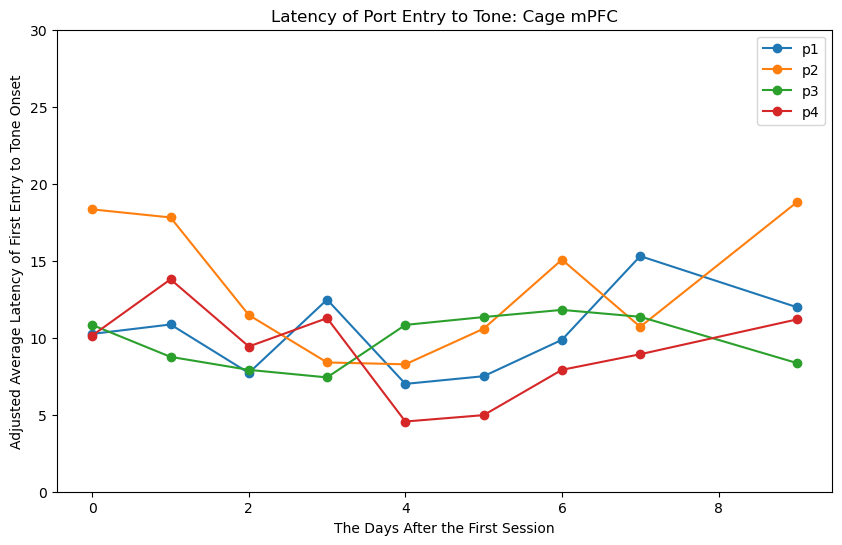

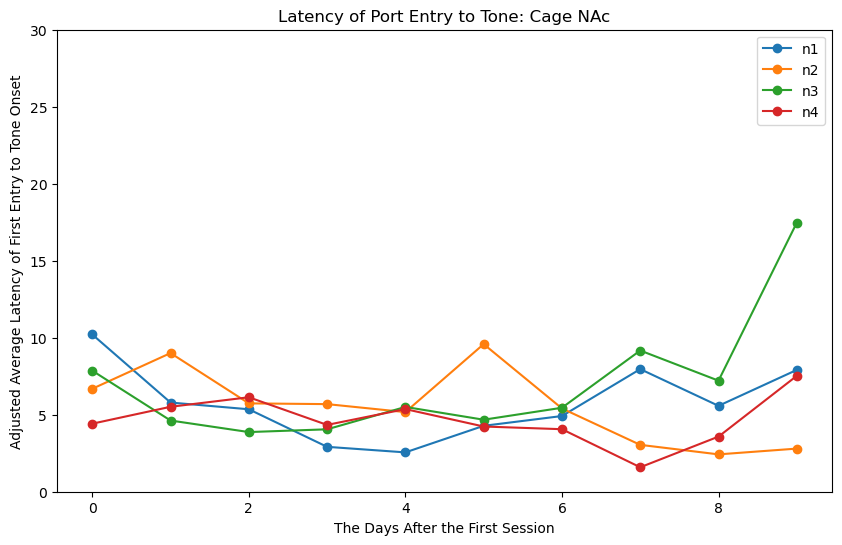

In [206]:
# Plotting for each cage
for cage in grouped_averaged_first_port_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_port_df[grouped_averaged_first_port_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date int"], subject_df["latency_adjusted_greater_than_30"], '-o', label=subject)

    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 30)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Adjusted Average Latency of First Entry to Tone Onset")
    ax.set_title("Latency of Port Entry to Tone: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    file_name = "average_latency_plot_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join(original_average_latency_output_directory, file_name))

## Plotting the original ratio of latencies that are less than 10 seconds

In [207]:
less_than_10_second_original_latency_ratio_plots_output_directory = "./proc/plots"

In [208]:
os.makedirs(less_than_10_second_original_latency_ratio_plots_output_directory, exist_ok=True)

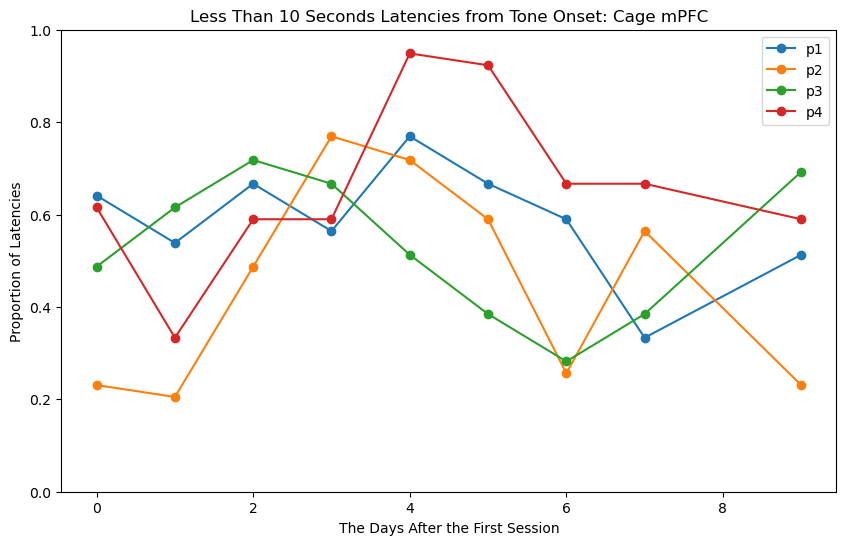

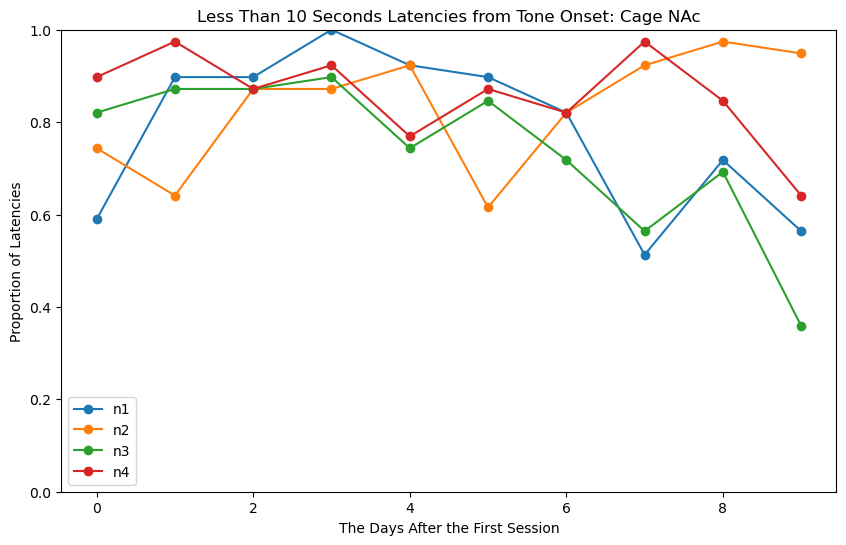

In [209]:
# Plotting for each cage
for cage in grouped_averaged_first_port_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_port_df[grouped_averaged_first_port_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date int"], subject_df["adjusted_30_second_latency_less_than_10_seconds_ratio"], '-o', label=subject)
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Proportion of Latencies")
    ax.set_title("Less Than 10 Seconds Latencies from Tone Onset: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    
    file_name = "10_less_latency_ratio_cage_{}.png".format(cage)
    plt.savefig(os.path.join(less_than_10_second_original_latency_ratio_plots_output_directory, file_name))

## Plotting the Adjusted Latencies for Entries that Overlap with the Tone
Plotting Latencies

In [210]:
overlap_adjusted_average_latency_plots_output_directory = "./proc/plots"

In [211]:
os.makedirs(overlap_adjusted_average_latency_plots_output_directory, exist_ok=True)

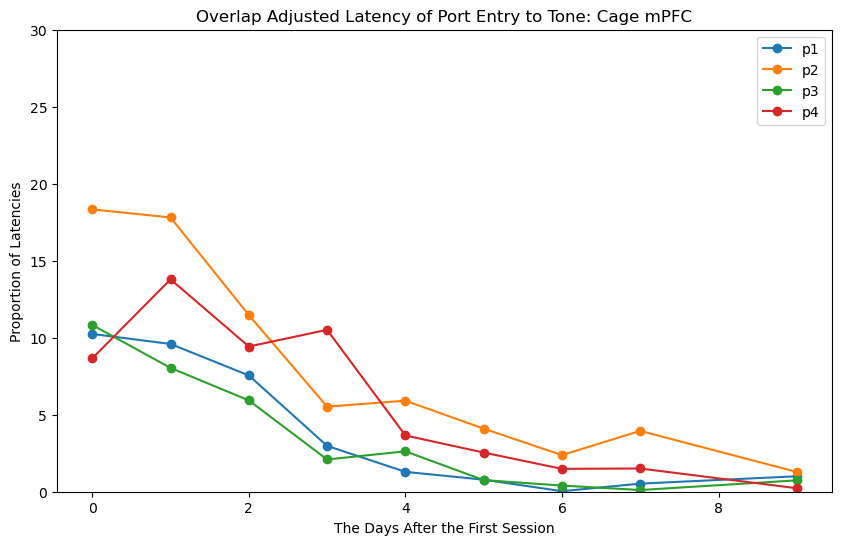

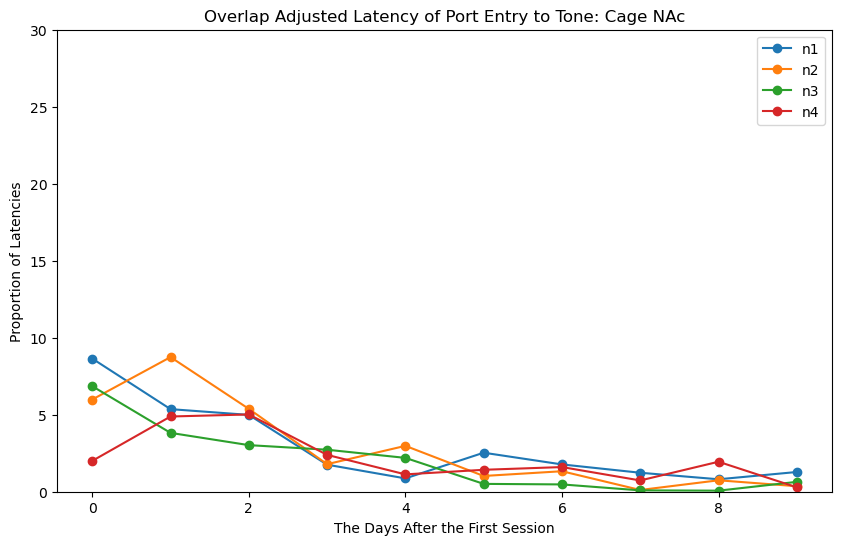

In [212]:
# Plotting for each cage
for cage in grouped_averaged_first_port_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_port_df[grouped_averaged_first_port_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date int"], subject_df["latency_adjusted_overlap"], '-o', label=subject)

    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 30)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Proportion of Latencies")
    ax.set_title("Overlap Adjusted Latency of Port Entry to Tone: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    file_name = "overlap_latency_cage_{}.png".format(cage)

    plt.savefig(os.path.join(overlap_adjusted_average_latency_plots_output_directory, file_name))


## Plotting the ratio of overlap adjusted latencies that are less than 10 seconds

In [213]:
less_than_10_second_overlap_adjusted_latency_ratio_output_directory = "./proc/plots"

In [214]:
os.makedirs(less_than_10_second_overlap_adjusted_latency_ratio_output_directory, exist_ok=True)

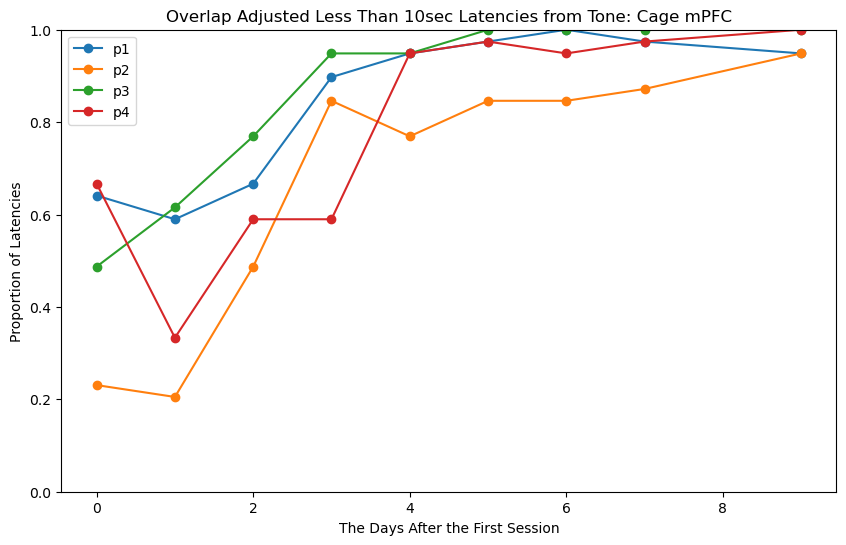

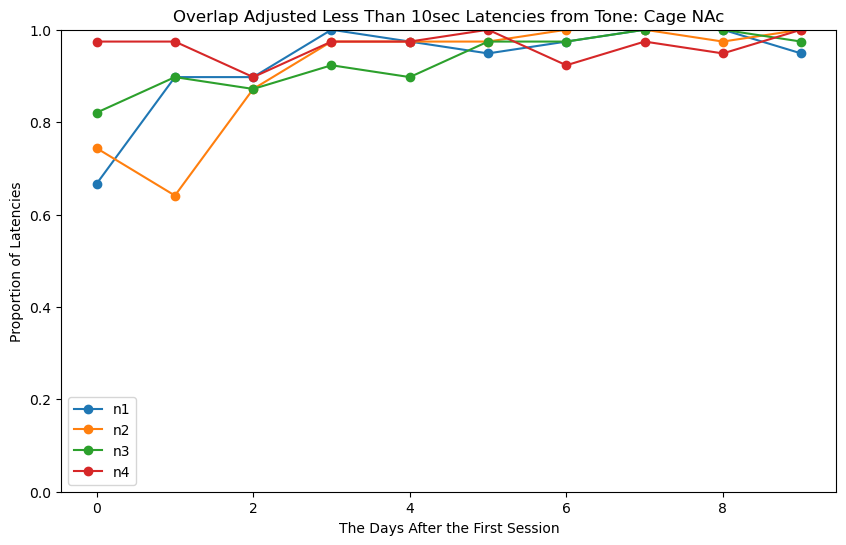

In [215]:
# Plotting for each cage
for cage in grouped_averaged_first_port_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_port_df[grouped_averaged_first_port_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date int"], subject_df["overlap_adjusted_latency_less_than_10_seconds"], '-o', label=subject)

    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Proportion of Latencies")
    ax.set_title("Overlap Adjusted Less Than 10sec Latencies from Tone: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    
    file_name = "10_less_overlap_latency_cage{}.png".format(cage)
    plt.savefig(os.path.join(less_than_10_second_overlap_adjusted_latency_ratio_output_directory, file_name))
